In [228]:
#!pip install -r content/requirements.txt 
!pip install -r requirements.txt 

In [229]:
#import os
#
## Lista de pastas a serem criadas
#folders = ['content/results', 'content/results/graphs', 'content/models', 'content/models/preprocessors']
#
## Criar pastas
#for folder in folders:
#    os.makedirs(folder, exist_ok=True)

In [230]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor as knr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

### Preprocess class 

In [231]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

class Preprocess:
    def __init__(self, data, numerical_features, categorical_features, boolean_features, target):
        self.data = data
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.boolean_features = boolean_features
        self.target = target

        self.features = self.numerical_features + self.categorical_features + self.boolean_features
    
    def create_lag_columns(self, lag_columns, lag_values, data=None):
        # Create lag columns
        for column, value in zip(lag_columns, lag_values):
            lag_column_name = column+f'_lag{value}'
            self.data[lag_column_name] = self.data[column].shift(value)

            if column in self.numerical_features or column == self.target:
                self.numerical_features.append(lag_column_name)
            elif column in self.categorical_features:
                self.categorical_features.append(lag_column_name)
            elif column in self.boolean_features:
                self.boolean_features.append(lag_column_name)
        
        # update features
        self.features = self.numerical_features + self.categorical_features + self.boolean_features 

        return self.data 
    
    def create_preprocessor(self, imputer_stategy=None, scale_std=False, scale_minmax=False):

        # Transformer to numerical columns
        if imputer_stategy is None:
            step = []
        else:
            step = [('imputer', SimpleImputer(strategy='mean'))] # If there are missing values, fill with the mean (Maybe change because of the lag columns)

        # Add scaler to the pipeline
        if scale_std and scale_minmax:
            raise ValueError('Only one scaler can be selected')
        elif scale_std:
            step.append(('scaler', StandardScaler()))
        elif scale_minmax:
            step.append(('scaler', MinMaxScaler()))

        if step != []:
            numeric_transformer = Pipeline(steps=step) # Pipeline to numerical columns
        else:
            numeric_transformer = 'passthrough'

        # Transformer to categorical columns
        categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

        # Transformers pipeline
        transformers = [
            ('num', numeric_transformer, self.numerical_features),
            ('cat', categorical_transformer, self.categorical_features),
            ('bool', 'passthrough', self.boolean_features)
        ]

        # Create the preprocessor
        preprocessor = ColumnTransformer(transformers=transformers)

        return preprocessor

### Model utils class

In [267]:
import pickle
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt

class Model_utils:
    def __init__(self):
        self.model = None
        self.model_name = None
        self.model_path = None
        self.preprocessor_path = None
        # create theme
        sns.set_theme(style="darkgrid")

    # Train the machine learning model (not a deep learning model)
    def train_model(self, model, X_train, y_train, model_name, preprocessor=None, save=True, grid_search=False, param_grid=None, cv=3, comments=None):
        
        # comments about the train model to be saved
        self.comments = comments

        if grid_search:
                
            # Grid search to find the best parameters
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2)
            grid_search.fit(X_train, y_train)
            self.best_params = grid_search.best_params_
            self.best_score = grid_search.best_score_
            model = model.set_params(**grid_search.best_params_)
                
        # Train the model
        model.fit(X_train, y_train)

        if save:
            if preprocessor is None:
                raise ValueError('You should save the preprocessor to save the model and preprocess the data after loading it!')                
            self.model = model
            self.model_name = model_name
            self.preprocessor = preprocessor
            self.save_model()
    
    # Save the model in a pickle file
    def save_model(self):
        now = datetime.now()
        now = now.strftime("%Y-%m-%d_%H-%M-%S")

        folder = 'content/models'
        file_name = f'{self.model_name}__{now}.pkl'
        preprocessor_folder = folder + '/preprocessors'
        preprocessor_name = f'{self.model_name}__{now}_preprocessor.pkl'

        self.model_path = f'{folder}/{file_name}'
        self.preprocessor_path = f'{preprocessor_folder}/{preprocessor_name}'

        with open(self.model_path, 'wb') as file:
            pickle.dump(self.model, file)

        with open(self.preprocessor_path, 'wb') as file:
            pickle.dump(self.preprocessor, file)

    # Load the model from a pickle file
    def load_model(self, model_path=None, preprocessor_path=None):
        
        # If the model path is not provided, use the model path that was saved (can be None)
        if self.model_path is None and model_path is None:
            raise ValueError('model_path is None. You need to provide a model path to load the model')
        elif model_path is not None:
            self.model_path = model_path

        # If the preprocessor path is not provided, use the preprocessor path that was saved (can be None)
        if self.preprocessor_path is None and preprocessor_path is None:
            print('preprocessor_path is None. You need to provide a preprocessor_path path to load the preprocessor')
        elif preprocessor_path is not None:
            self.preprocessor_path = preprocessor_path

        
        # load the model
        with open(self.model_path, 'rb') as file:
            self.model = pickle.load(file)

        # load the preprocessor
        if self.preprocessor_path is not None:
            with open(self.preprocessor_path, 'rb') as file:
                self.preprocessor = pickle.load(file)

            return self.model, self.preprocessor
        
        else:
            return self.model            

    # Test the model and save the metrics in a csv file 
    def test_model(self, X_test, y_test, save_metrics=True, return_error_metrics=False):
        y_pred = self.model.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse ** 0.5
        r2 = r2_score(y_test, y_pred)
        
        
        if save_metrics:
            self.save_csv_results(mae, mse, rmse, r2)

        if return_error_metrics:
            return y_pred, mae, mse, rmse, r2
        else:
            return y_pred
    
    def save_csv_results(self, mae, mse, rmse, r2):
        now = datetime.now()
        now = now.strftime("%Y-%m-%d_%H-%M-%S")

        folder = 'content/results'
        file_name = 'history.csv'

        # if the file does not exist, create the header
        try:
            with open(f'{folder}/{file_name}', 'r') as file:
                pass
        except FileNotFoundError:
            with open(f'{folder }/{file_name}', 'w') as file:
                file.write('model_name,date,MAE,MSE,RMSE,R2,model_params,comments\n') 

        # Append the results
        with open(f'{folder}/{file_name}', 'a') as file:            
            file.write(f'{self.model_name},{now},{mae},{mse},{rmse},{r2},\"{self.model.get_params()}\",\"{self.comments}\"\n')


    def plot_predictions(self,  X_test, y_true, graph_name='prediction', save=True, print_error=True):
        
        # Calcule error metrics
        y_pred, mae, mse, rmse, r2 = self.test_model(X_test, y_true, save_metrics=False, return_error_metrics=True)
        
        # Create the error bands
        upper_band = y_pred + rmse
        lower_band = y_pred - rmse

        
        # Create a figure and axis  
        fig, ax = plt.subplots(figsize=(15, 7))

        # Plot the true values
        sns.lineplot(x=range(len(y_true)), y=y_true, label='True Values', ax=ax)

        # Plot the predicted values
        sns.lineplot(x=range(len(y_pred)), y=y_pred, label='Predicted Values', ax=ax)

        # Plot the error bands
        ax.fill_between(range(len(y_pred)), lower_band, upper_band, alpha=0.3, label='Error Band', color='yellow')

        # Set the title
        ax.set_title('Consumo de energia médio diário do forno')
        # Set the y label
        ax.set_ylabel('Consumo de energia (MWh/dia)')

        # Set the legend
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # print error metrics
        if print_error:
            print(f'MAE:  {mae}')
            print(f'MSE:  {mse}')
            print(f'RMSE: {rmse}')
            print(f'R2:   {r2}')

        if save:
            save_graph_path = 'content/results/graphs/'
            # Save the plot
            fig.savefig(save_graph_path + graph_name + '.png')

    def batch_predictions(self, X_test, y_true, nb_batches=30):
        X_test_batches = np.array_split(X_test, nb_batches)
        y_true_batches = np.array_split(y_true, nb_batches)

        mae = []
        mse = []
        rmse = []
        r2 = []

        y_pred = []
        for X_batch, y_batch in zip(X_test_batches, y_true_batches):

            y_pred_batch = self.model.predict(X_batch)
            y_pred.append(y_pred_batch)

            # error metrics
            mae.append(mean_absolute_error(y_batch, y_pred_batch)) 
            mse.append(mean_squared_error(y_batch, y_pred_batch))
            rmse.append(mean_squared_error(y_batch, y_pred_batch) ** 0.5)
            #r2.append(r2_score(y_batch, y_pred_batch))

         # Convert y_pred to numpy array for consistency
        y_pred = np.concatenate(y_pred)
        mae = np.array(mae) 
        mse = np.array(mse)
        rmse = np.array(rmse)
        #r2 = np.array(r2)

        fig, ax  = plt.subplots(3, 1, figsize=(10,10))

        #ax[0].figure(figsize=(10, 6))
        ax[0].boxplot(mae, tick_labels=['MAE'])
        ax[0].set_title('Boxplot of MAE')
        ax[0].set_ylabel('Values')

        #ax[1].figure(figsize=(10, 6))
        ax[1].boxplot(mse, tick_labels=['MSE'])
        ax[1].set_title('Boxplot of MSE')
        ax[1].set_ylabel('Values')

        #ax[2].figure(figsize=(10, 6))
        ax[2].boxplot(rmse, tick_labels=['RMSE'])
        ax[2].set_title('Boxplot of RMSE')
        ax[2].set_ylabel('Values')

        #plt.figure(figsize=(10, 6))
        #plt.boxplot(r2, labels=['R2'])
        #plt.title('Boxplot of R2')
        #plt.ylabel('Values')
        #plt.show()




## Load Data

In [268]:
class LoadData:
    def __init__(self, path='content/cleaned_data_train.xlsx'):
        data = pd.read_excel(path)

        # Rename columns
        data.rename(columns={
            'BOOSTING (MWH)': 'boosting',
            'Cor': 'cor',
            'Prod_E': 'prod_e',
            'Prod_L': 'prod_l',
            'Espess.': 'espessura',
            'Extração forno': 'extracao_forno',
            '%CACO': 'porcentagem_caco',
            'Médio diário': 'medio_diario'
        }, inplace=True)

        # Standardize string columns to lowercase
        data = data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

        # Add week_day column
        data['week_day'] = data['Data'].dt.dayofweek

        # Create a different dataframe with only the last month data
        last_month = data['Data'].max()
        self.last_month_data = data[data['Data'] >= last_month.replace(day=1)]
        self.data = data[data['Data'] < last_month.replace(day=1)]

        # Identify categorical and numerical columns
        self.boolean_features = ['prod_e', 'prod_l']  # Boolean columns
        self.categorical_features = ['cor', 'week_day']  # Categorical columns
        self.numerical_features = ['boosting', 'espessura', 'extracao_forno', 'porcentagem_caco']  # Numerical columns
        
        self.features = self.numerical_features + self.categorical_features + self.boolean_features
        self.target = 'medio_diario'


In [269]:
# Only to not have to do it at each new model
def init_data_and_preprocess():
    # Creating LoadData object
    load_data = LoadData()
    # Creating Preprocess object
    preprocess = Preprocess(load_data.data, load_data.numerical_features, load_data.categorical_features,
                             load_data.boolean_features,load_data.target)

    return load_data, preprocess

## XGboost

#### Load and preprocess Data

XGboost and RF models will use the same preprocess pipeline (what can be explained by both are tree-based models)

In [270]:
load_data, preprocess = init_data_and_preprocess()

lag_columns_list = ['medio_diario']*7
lag_values = [1, 2, 3, 4, 5, 6, 7]

# create the lagged columns in data
data = preprocess.create_lag_columns(lag_columns_list, lag_values)

In [271]:
data.head()

,Data,prod_e,prod_l,boosting,cor,espessura,extracao_forno,porcentagem_caco,medio_diario,week_day,medio_diario_lag1,medio_diario_lag2,medio_diario_lag3,medio_diario_lag4,medio_diario_lag5,medio_diario_lag6,medio_diario_lag7
0,2023-01-01,0,0,0.0,incolor,10,651.623752,10.005774,4.3800,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,0,0,0.0,incolor,8,649.535068,10.007158,4.6551,0,4.3800,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-03,1,0,0.0,incolor,8,647.888229,10.001725,4.6337,1,4.6551,4.3800,NaN,NaN,NaN,NaN,NaN
3,2023-01-04,0,0,0.0,incolor,8,647.669957,10.005096,4.5802,2,4.6337,4.6551,4.3800,NaN,NaN,NaN,NaN
4,2023-01-05,0,0,0.0,incolor,8,647.762743,10.003663,4.6078,3,4.5802,4.6337,4.6551,4.38,NaN,NaN,NaN


In [272]:
# removing the first 7 rows
data = data.iloc[7:]

X = data[preprocess.features]
y = data[preprocess.target]

# Scale is not needed for XGBoost (it is a tree-based model)
preprocessor = preprocess.create_preprocessor(scale_std=False, scale_minmax=False)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train = preprocessor.fit_transform(X_train)

##### Train

In [273]:
# comments to be saved in the history
comments = 'best xgboost removing last month data before shuffle'

# Train the model
model_name = 'xgboost' #name the model to save it in models + the metrics in history.csv

# Create the XGBRegressor model
model = xgb.XGBRegressor(objective='reg:squarederror', enable_categorical='True',
                         n_estimators= 1300, max_depth= 3, learning_rate= 0.01,
                         gamma= 0, subsample= 0.3, reg_alpha= 0.5,
                         reg_lambda= 0, random_state= 42)

model_utils = Model_utils()

# Train the model with the best parameters
model_utils.train_model(model, X_train, y_train, model_name, preprocessor=preprocessor, grid_search=False, comments=comments)


##### Validation

In [274]:
# Load the model with the best parameters + the preprocessor
print(f'Loaded model: {model_utils.model_path}')
model, preprocessor = model_utils.load_model(model_utils.model_path) 
# or to load a specific model, provide the path to the model like 'content/models/xgboost__2024-07-02_02-55-14.pkl'

# Preprocess the test data
X_test = preprocessor.transform(X_test)

# Test the model
y_pred = model_utils.test_model(X_test, y_test)

Loaded model: content/models/xgboost__2024-07-08_20-05-10.pkl


/home/kr0pt/Documents/vivix_test/venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


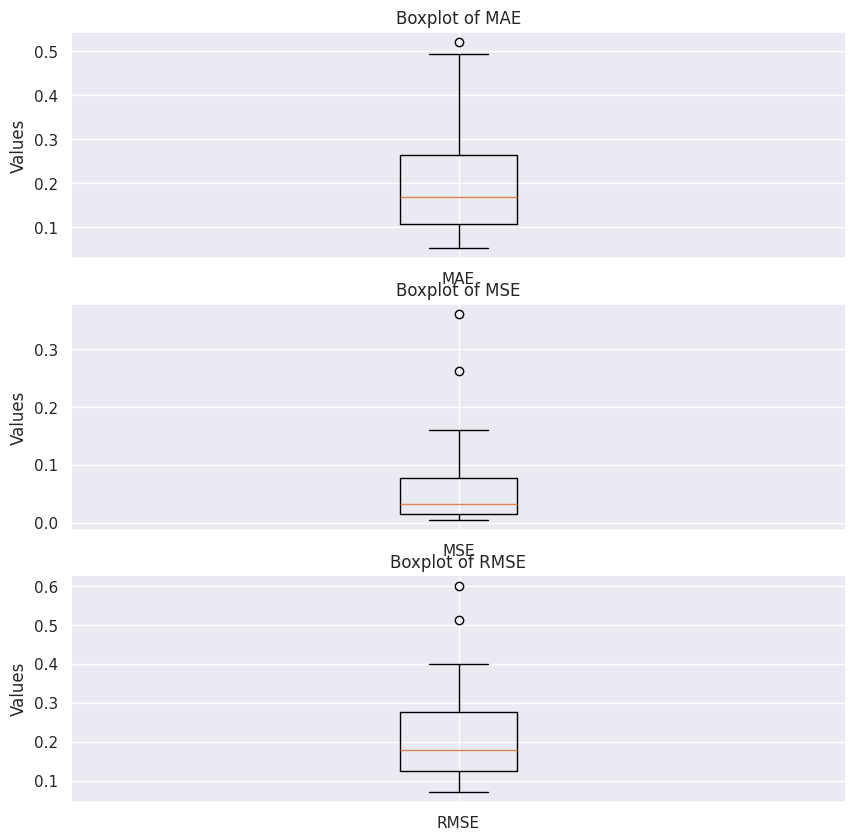

In [275]:
model_utils.batch_predictions(X_test, y_test, nb_batches=30)

In [276]:
y_pred

array([4.6641426, 4.810725 , 4.5487103, 4.8290663, 4.775466 , 4.258663 ,
       4.500127 , 4.0280585, 4.3972406, 4.63656  , 5.226875 , 4.681993 ,
       4.559661 , 4.975426 , 4.554141 , 4.498277 , 4.874851 , 4.836928 ,
       4.769099 , 4.5059357, 5.0875697, 4.3704224, 4.79071  , 4.1274543,
       5.0011983, 4.980507 , 4.491531 , 4.8542676, 4.739016 , 4.851067 ,
       4.7620487, 4.759637 , 5.267038 , 4.7855883, 4.612331 , 4.371084 ,
       5.0035195, 5.0674043, 4.846629 , 4.354614 , 4.539456 , 5.057458 ,
       4.749076 , 4.3040786, 4.8099003, 4.943994 , 4.435103 , 4.884432 ,
       5.0682793, 4.5070615, 5.3004313, 4.619572 , 4.91694  , 4.561791 ,
       4.211517 , 5.3398995, 4.781246 , 5.2010593, 4.7719917, 4.397662 ,
       4.531577 , 4.7263   , 4.3542566, 4.3921385, 4.2696986, 4.309671 ,
       4.7493563, 4.415944 , 5.005621 , 4.477245 , 5.318474 , 4.4511657,
       4.26333  , 4.733831 , 4.8137164, 4.9138207, 4.4288597, 4.024404 ],
      dtype=float32)

Using the model: xgboost__2024-07-08_20-05-10 to plot predictions...
MAE:  0.19947414494271562
MSE:  0.06622769331297776
RMSE: 0.25734741753702867
R2:   0.5685095723136878


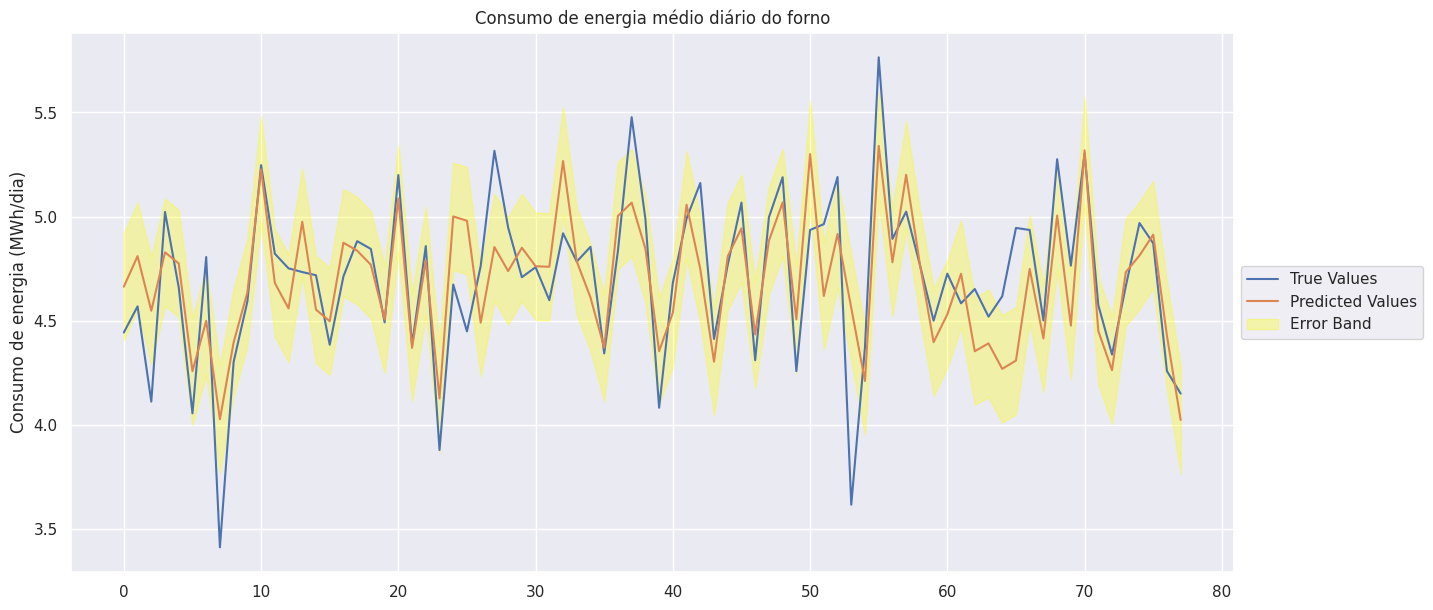

In [277]:
last_trained_model = model_utils.model_path.split('/')[-1].split('.')[0] # get the name__date.pkl of the model
print(f'Using the model: {last_trained_model} to plot predictions...')
model_utils.plot_predictions(X_test, y_test, last_trained_model)

#### Test

This step is like the validation step. But here we upload only the last month and seven days before it (this data is not into the training/validation data) to do a sequencial (in time) prediction and a simulation that what will be done in production

In [278]:
load_data, preprocess = init_data_and_preprocess()

# load the test data
test_data = load_data.last_month_data
data_last_7_days = load_data.data.tail(7) # the last 7 days before the last month will be used as lagged features

# Union the last 7 days data with the last month data
test_data = pd.concat([data_last_7_days,test_data], ignore_index=True)

In [279]:
# Create the preprocess object for the test data
# the columns are the same of the training data so we can use the load_data object
preprocess = Preprocess(test_data, load_data.numerical_features, load_data.categorical_features,
                         load_data.boolean_features, load_data.target)

# lag feature and create a dataframe to each model
lag_columns_list = ['medio_diario']*7
lag_values = [1, 2, 3, 4, 5, 6, 7]

test_data = preprocess.create_lag_columns(lag_columns_list, lag_values)

# removing the first 7 rows after lagging
test_data = test_data.iloc[7:]

# Define the features and targets
X_test = test_data[preprocess.features]
y_test = test_data[preprocess.target]

# Preprocess the data (doing the inputation, scaling if it was used in training)
X_test = preprocessor.transform(X_test)

In [280]:
# loading the model

# if you want to load a model that was not the last trained model, provide the path to the model
#model_path=f'content/models/{model_name}__{model_date}.pkl'
#preprocessor_path = f'content/models/preprocessors/{model_name}__{model_date}_preprocessor.pkl'

model, preprocessor = model_utils.load_model(model_path=model_utils.model_path, preprocessor_path=model_utils.preprocessor_path)
# Model prediction
y_pred = model.predict(X_test)

display(y_pred)

array([5.388836 , 5.2865133, 4.920804 , 4.8906465, 5.3126655, 5.4743905,
       5.38657  , 5.323462 , 5.1346145, 5.045853 , 5.1250715, 5.294147 ,
       5.331264 , 5.382345 ], dtype=float32)

Using the model: xgboost__2024-07-08_20-05-10 to plot predictions...
MAE:  0.2861072947227841
MSE:  0.12482092656584567
RMSE: 0.3533000517489994
R2:   -0.4197180083704728


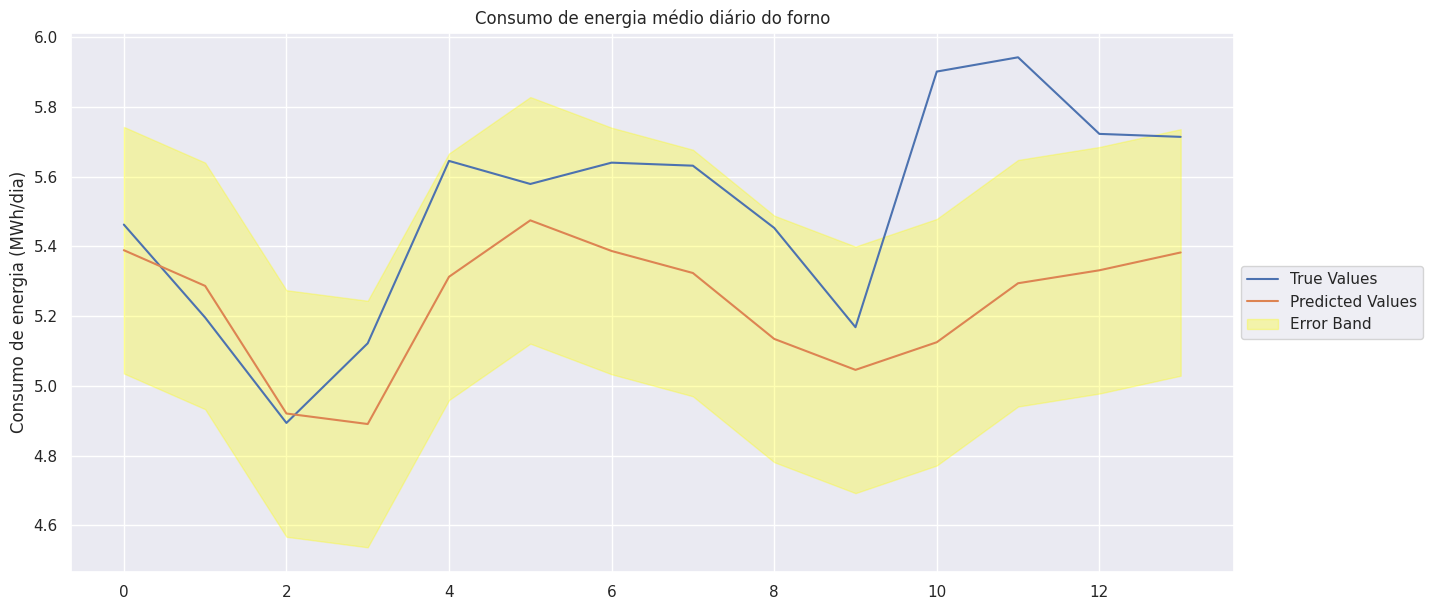

In [281]:
last_trained_model = model_utils.model_path.split('/')[-1].split('.')[0] # get the name__date.pkl of the model
print(f'Using the model: {last_trained_model} to plot predictions...')
model_utils.plot_predictions(X_test, y_test, last_trained_model)

## Random Forest

#### Load and preprocess Data

In [282]:
load_data, preprocess = init_data_and_preprocess()

# lagging columns
lag_columns_list = ['medio_diario']*7
lag_values = [1, 2, 3, 4, 5, 6, 7]

# load train/validation data
data = load_data.data

# create the lagged columns in data
data = preprocess.create_lag_columns(lag_columns_list, lag_values)
data = data.iloc[7:]

features = preprocess.features
target = preprocess.target

X = data[features]
y = data[target]

# Scale is not needed for XGBoost (it is a tree-based model)
preprocessor = preprocess.create_preprocessor(scale_std=False, scale_minmax=False)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Preprocess the data
X_train = preprocessor.fit_transform(X_train)

##### Train

In [283]:
# comments to be saved in the history
comments = 'best Random Forest + removing last month data before shuffle'

# Train the model
model_name = 'Random_Forest'

# Create the Random Forest model
model = RandomForestRegressor(n_estimators=400, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', random_state=42)
model_utils = Model_utils()

# Train the model with the best parameters
model_utils.train_model(model, X_train, y_train, model_name, preprocessor=preprocessor, grid_search=False, comments=comments)


##### Validation

In [284]:
# Load the model with the best parameters + the preprocessor
print(f'Loaded model: {model_utils.model_path}')
model, preprocessor =  model_utils.load_model(model_utils.model_path) 

# Preprocess the test data (already preprocessed)
X_test = preprocessor.transform(X_test)

# Test the model
y_pred = model_utils.test_model(X_test, y_test)

Loaded model: content/models/Random_Forest__2024-07-08_20-05-12.pkl


/home/kr0pt/Documents/vivix_test/venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


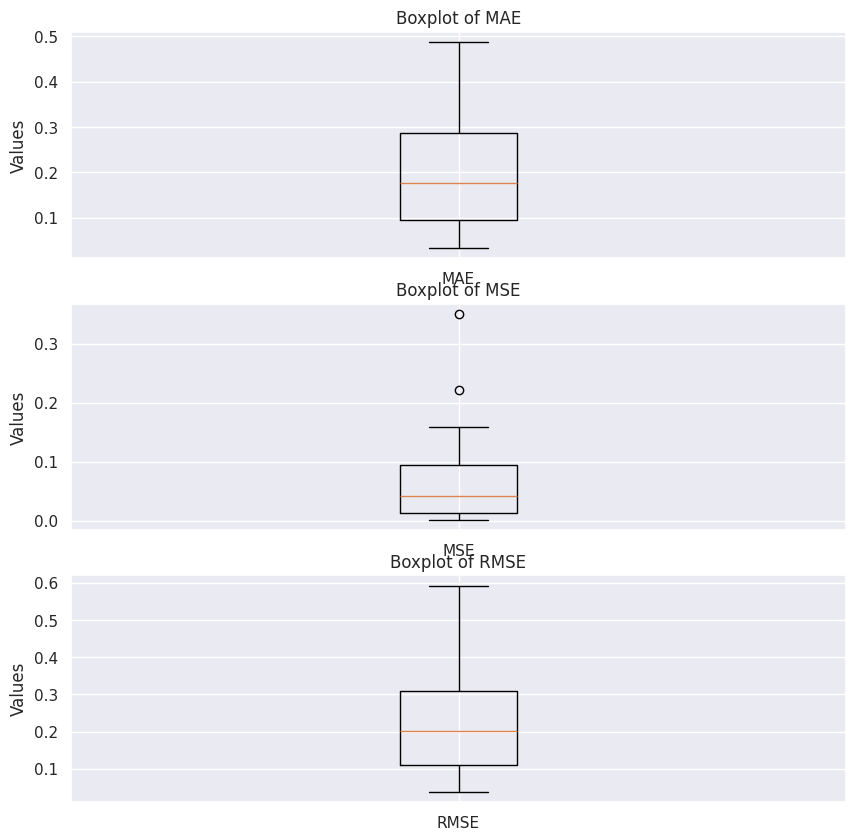

In [285]:
model_utils.batch_predictions(X_test, y_test, nb_batches=30)

In [286]:
y_pred

array([4.62926807, 4.8111874 , 4.56341953, 4.72344663, 4.86597857,
       4.49518587, 4.46950158, 4.1499755 , 4.39174609, 4.56822278,
       5.23552354, 4.75988799, 4.62483207, 4.85940002, 4.73842539,
       4.41557769, 4.76340579, 4.77785039, 4.744246  , 4.52354734,
       5.06958763, 4.41261488, 4.89822916, 4.31363378, 4.97530512,
       4.87213432, 4.5042672 , 4.89623472, 4.71426774, 4.85442388,
       4.69668298, 4.67623847, 5.08540555, 4.63086821, 4.70500364,
       4.49418029, 5.01154448, 5.05833041, 4.76958334, 4.36419408,
       4.4389085 , 5.05516603, 4.71952434, 4.31711191, 4.7532663 ,
       5.00377042, 4.59265347, 4.856638  , 5.02018421, 4.73413707,
       5.21579149, 4.72647225, 4.92831706, 4.58121131, 4.30472347,
       5.20615021, 4.79622338, 5.06622314, 4.66048564, 4.55669377,
       4.52316835, 4.75603823, 4.46484851, 4.47849179, 4.33340371,
       4.4644122 , 4.77725219, 4.47561054, 5.01921691, 4.55680507,
       5.15120947, 4.69540937, 4.37959384, 4.70418301, 4.77834

Using the model: Random_Forest__2024-07-08_20-05-12 to plot predictions...
MAE:  0.20046630959866432
MSE:  0.06953146071740225
RMSE: 0.2636881884298238
R2:   0.5469846793421871


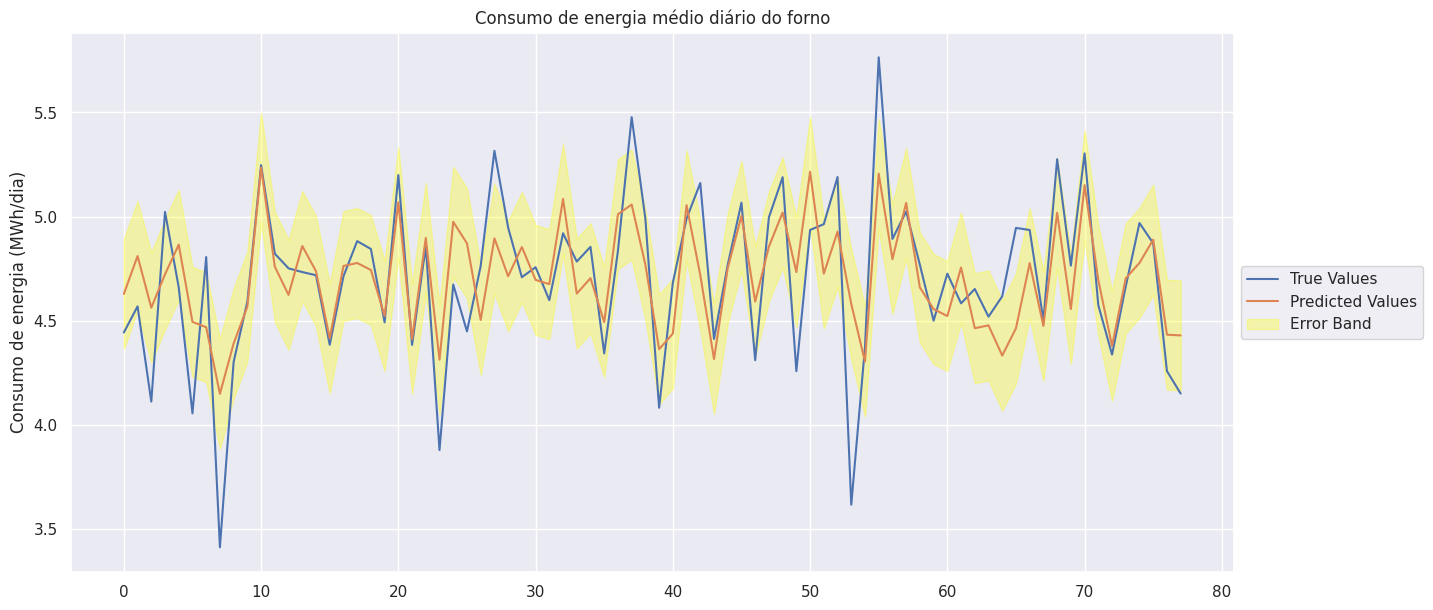

In [287]:
last_trained_model = model_utils.model_path.split('/')[-1].split('.')[0] # get the name__date.pkl of the model
print(f'Using the model: {last_trained_model} to plot predictions...')
model_utils.plot_predictions(X_test, y_test, last_trained_model)

#### Test

This step is like the validation step. But here we upload only the last month and seven days before it (this data is not into the training/validation data) to do a sequencial (in time) prediction and a simulation that what will be done in production

In [288]:
# Creating the data (it's not the preprocessing)
load_data, preprocess = init_data_and_preprocess()

# load the test data
test_data = load_data.last_month_data
data_last_7_days = load_data.data.tail(7) # the last 7 days before the last month will be used as lagged features

# Union the last 7 days data with the last month data
test_data = pd.concat([data_last_7_days,test_data], ignore_index=True)

In [289]:
# Preprocessing here!
preprocess = Preprocess(test_data, load_data.numerical_features, load_data.categorical_features,
                         load_data.boolean_features, load_data.target)

# lag features
lag_columns_list = ['medio_diario']*7
lag_values = [1, 2, 3, 4, 5, 6, 7]

test_data = preprocess.create_lag_columns(lag_columns_list, lag_values)

# removing the first 7 rows after lagging
test_data = test_data.iloc[7:]

# Define the features and targets
X_test = test_data[preprocess.features]
y_test = test_data[preprocess.target]

# Preprocess the data (doing the inputation, scaling if it was used in training)
X_test = preprocessor.transform(X_test)

In [290]:
# loading the model
#model_path=f'models/{model_name}__{model_date}.pkl'
#preprocessor_path = f'models/preprocessors/{model_name}__{model_date}_preprocessor.pkl'


model, preprocessor = model_utils.load_model(model_path=model_utils.model_path, preprocessor_path=model_utils.preprocessor_path)

# Model prediction
y_pred = model.predict(X_test)
display(y_pred)

array([5.3659442 , 5.28845416, 5.02667823, 4.93710599, 5.20642458,
       5.381496  , 5.38021887, 5.27292596, 5.17978572, 5.0855339 ,
       5.12823503, 5.30826612, 5.34884723, 5.31647257])

Using the model: Random_Forest__2024-07-08_20-05-12 to plot predictions...
MAE:  0.3065661919369244
MSE:  0.1337714827592434
RMSE: 0.36574784040270614
R2:   -0.5215219779636262


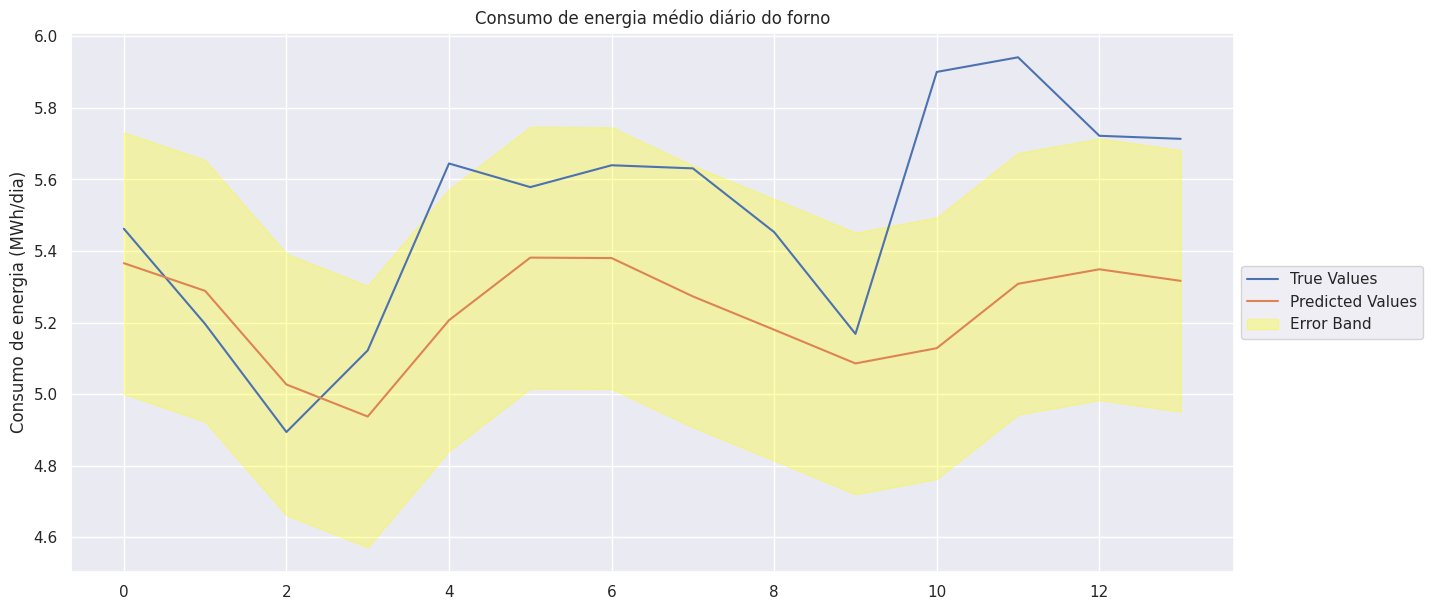

In [291]:
last_trained_model = model_utils.model_path.split('/')[-1].split('.')[0] # get the name__date.pkl of the model
print(f'Using the model: {last_trained_model} to plot predictions...')
model_utils.plot_predictions(X_test, y_test, last_trained_model)

## KNN

#### Load and preprocess Data

In [292]:
load_data, preprocess = init_data_and_preprocess()

# lagging columns
lag_columns_list = ['medio_diario']*7
lag_values = [1, 2, 3, 4, 5, 6, 7]
lag_columns_list += load_data.features
lag_values += [1]*len(load_data.features)

# load train/validation data
data = load_data.data

# create the lagged columns in data
data = preprocess.create_lag_columns(lag_columns_list, lag_values)
data = data.iloc[7:]

features = preprocess.features
target = preprocess.target

X = data[features]
y = data[target]

# Scale is not needed for XGBoost (it is a tree-based model)
preprocessor = preprocess.create_preprocessor(scale_std=True, scale_minmax=False)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
X_train = preprocessor.fit_transform(X_train)

##### Train

In [293]:
# Explain the train
comments = 'best KNN model. Removed last month data before shuffle. lagging all features.'

# Train the model
model_name = 'KNN'

# Create the KN-Regressor model
model = knr(algorithm='auto', leaf_size=1, n_neighbors= 5, p=1, weights ='distance')

model_utils = Model_utils()

# Train the model with the best parameters
#model_utils.train_model(model, X_train, y_train, model_name, preprocessor=preprocessor, grid_search=True, param_grid=param_grid, comments=comments)
model_utils.train_model(model, X_train, y_train, model_name, preprocessor=preprocessor, grid_search=False, comments=comments)

##### Validation

In [294]:
# Load the model with the best parameters + the preprocessor
print(f'Loaded model: {model_utils.model_path}')
model, preprocessor =  model_utils.load_model(model_utils.model_path) 


# Preprocess the test data
X_test = preprocessor.transform(X_test)

# Test the model
y_pred = model_utils.test_model(X_test, y_test)

Loaded model: content/models/KNN__2024-07-08_20-05-15.pkl


/home/kr0pt/Documents/vivix_test/venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


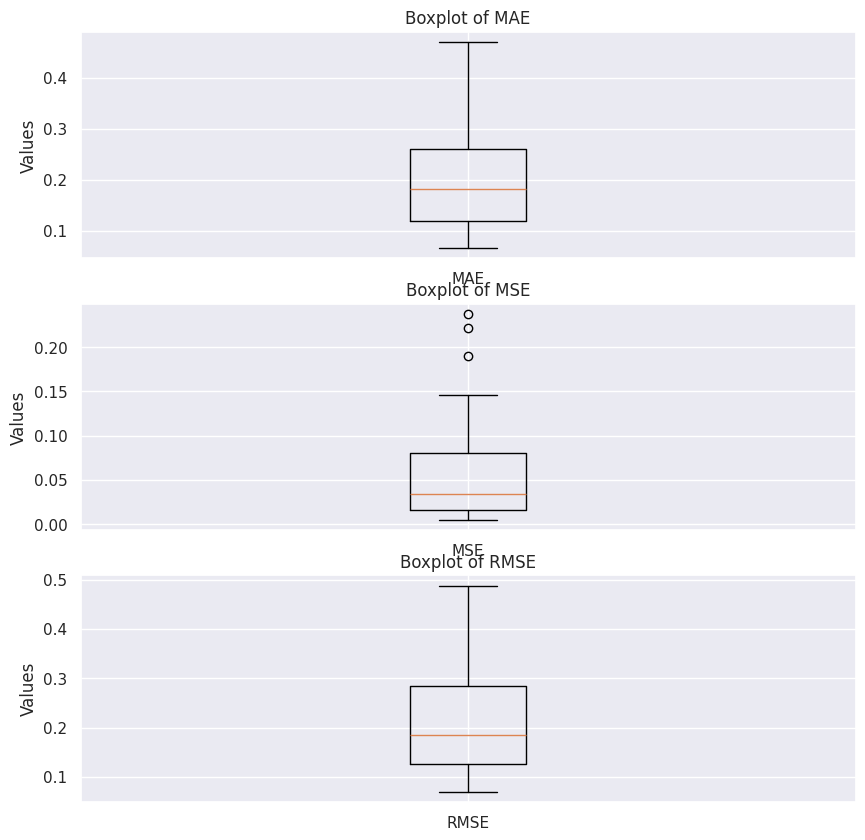

In [295]:
model_utils.batch_predictions(X_test, y_test, nb_batches=30)

In [296]:
y_pred

array([4.58308131, 4.72974406, 4.26251016, 4.73028686, 4.96219359,
       4.5296568 , 4.37460569, 3.66235645, 4.30263276, 4.47358153,
       5.19724056, 4.74069742, 4.43189818, 4.99673794, 4.49505422,
       4.49626389, 4.61966589, 4.652934  , 4.93926173, 4.431275  ,
       5.24561267, 4.23578378, 5.00350067, 4.10417247, 4.86793805,
       4.63440904, 4.52273957, 5.15291046, 4.70116042, 4.76216984,
       4.6188217 , 4.79647849, 5.15684666, 4.67579348, 4.77203984,
       4.38768711, 5.156196  , 5.15863351, 4.9162907 , 4.27521315,
       4.33049124, 5.01848927, 4.9901545 , 4.34922529, 4.59078536,
       5.17803038, 4.33708201, 5.11655721, 4.93650805, 4.80166401,
       5.49051656, 4.60921676, 4.96674352, 4.10897003, 4.26171904,
       5.23645295, 4.80812817, 5.1392822 , 4.15516026, 4.45429245,
       4.55091255, 4.44842367, 4.34986309, 4.66295362, 4.27842392,
       4.34599984, 4.70138916, 4.67824778, 5.04314972, 4.37482987,
       5.21462142, 4.71991942, 4.13477279, 4.71132879, 4.87805

Using the model: KNN__2024-07-08_20-05-15 to plot predictions...
MAE:  0.20129479267536388
MSE:  0.06109636463613386
RMSE: 0.24717678822278977
R2:   0.6019414962508083


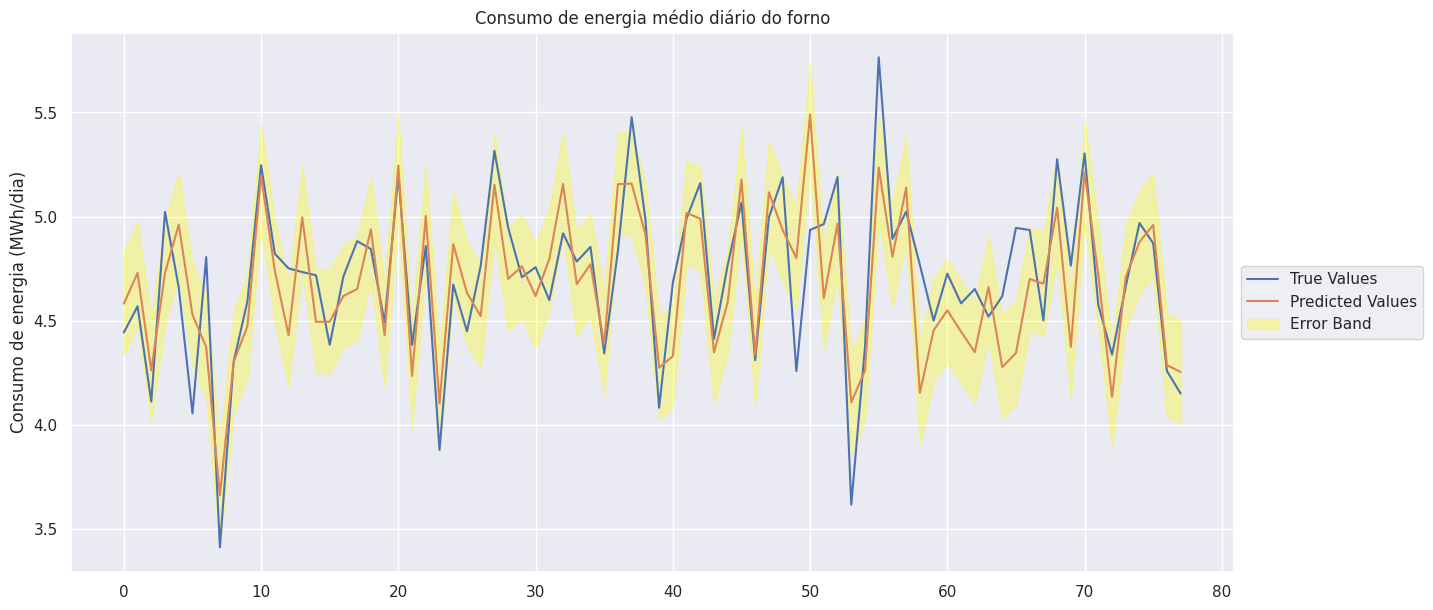

In [297]:
last_trained_model = model_utils.model_path.split('/')[-1].split('.')[0] # get the name__date.pkl of the model
print(f'Using the model: {last_trained_model} to plot predictions...')
model_utils.plot_predictions(X_test, y_test, last_trained_model)

#### Test

This step is like the validation step. But here we upload only the last month and seven days before it (this data is not into the training/validation data) to do a sequencial (in time) prediction and a simulation that what will be done in production

In [263]:
# Creating the data (it's not the preprocessing)
load_data, preprocess = init_data_and_preprocess()
# load the test data
test_data = load_data.last_month_data
data_last_7_days = load_data.data.tail(7) # the last 7 days before the last month will be used as lagged features

# Union the last 7 days data with the last month data
test_data = pd.concat([data_last_7_days,test_data], ignore_index=True)

In [264]:
# Preprocessing here!
preprocess = Preprocess(test_data, load_data.numerical_features, load_data.categorical_features,
                         load_data.boolean_features, load_data.target)

# lag features
lag_columns_list = ['medio_diario']*7
lag_values = [1, 2, 3, 4, 5, 6, 7]
lag_columns_list += load_data.features
lag_values += [1]*len(load_data.features)

# create the lagged columns in data
test_data = preprocess.create_lag_columns(lag_columns_list, lag_values)

# removing the first 7 rows after lagging
test_data = test_data.iloc[7:]

# Define the features and targets
X_test = test_data[preprocess.features]
y_test = test_data[preprocess.target]

# Preprocess the data (doing the inputation, scaling if it was used in training)
X_test = preprocessor.transform(X_test)

In [265]:
# loading the model
#model_path=f'models/{model_name}__{model_date}.pkl'
#preprocessor_path = f'models/preprocessors/{model_name}__{model_date}_preprocessor.pkl'

model, preprocessor = model_utils.load_model(model_path=model_utils.model_path, preprocessor_path=model_utils.preprocessor_path)

# Model prediction
y_pred = model.predict(X_test)
display(y_pred)

array([5.47499352, 5.37453666, 5.17516823, 5.09793643, 5.17811236,
       5.31944879, 5.37508094, 5.19467728, 5.23928151, 5.04349556,
       5.21330755, 5.3971227 , 5.38598201, 5.33588378])

Using the model: KNN__2024-07-08_20-03-38 to plot predictions...
MAE:  0.3005653951204752
MSE:  0.12451684037939866
RMSE: 0.35286943814872757
R2:   -0.41625932041747316


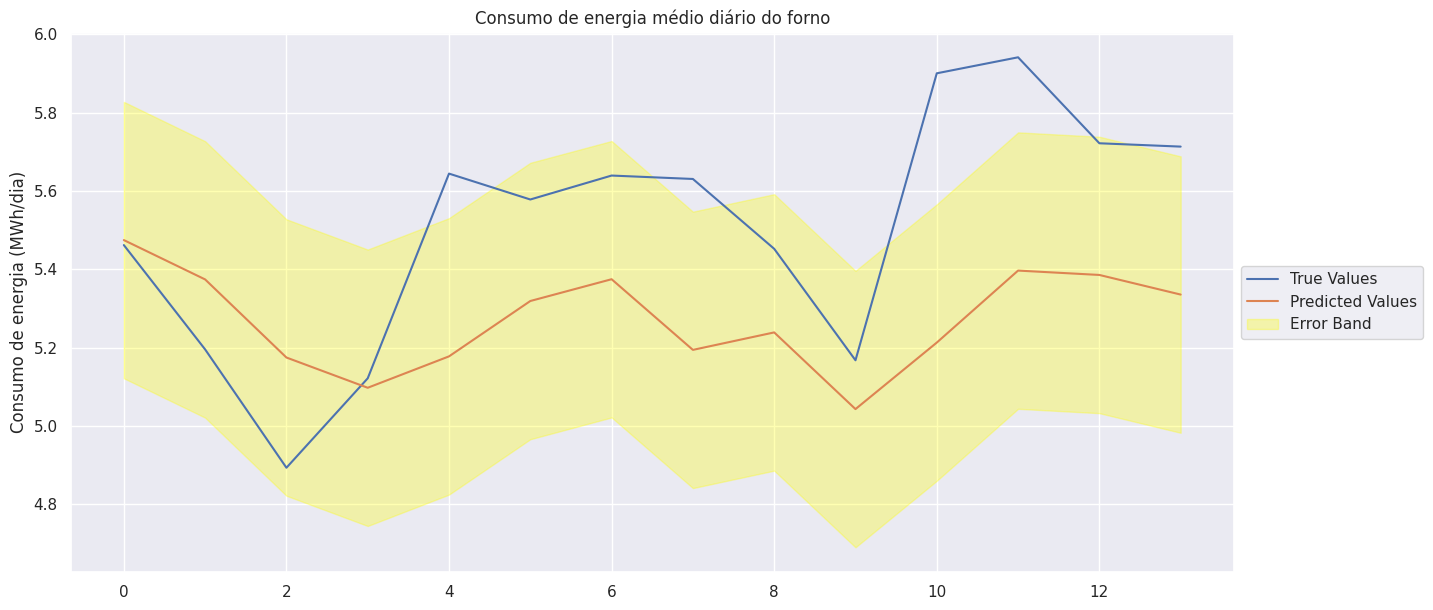

In [266]:
last_trained_model = model_utils.model_path.split('/')[-1].split('.')[0] # get the name__date.pkl of the model
print(f'Using the model: {last_trained_model} to plot predictions...')
model_utils.plot_predictions(X_test, y_test, last_trained_model)